# Import des librairies

In [1]:
#Manipulation des données
import pandas as pd
import numpy as np
#Graphiques
import matplotlib.pyplot as plt
import seaborn as sns
#Statistique
from scipy.stats import norm, t, shapiro, mannwhitneyu, ttest_ind

#Regression linéaire multiple
import statsmodels.api
import statsmodels.formula.api as smf
#Calcul vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Test de Durbin_Watson
from statsmodels.stats.stattools import durbin_watson
#Standardisation les données
from sklearn.preprocessing import StandardScaler
#Calculs des mesures de performance
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support,mean_squared_error,roc_curve,auc

#Regression logistique
from sklearn.linear_model import LogisticRegression
#Sélection des variables significatives
from sklearn.feature_selection import RFE
#Sampling et validation croisée
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

#KMeans
from sklearn.cluster import KMeans

# Fonctions

In [2]:
# Définitions des couleurs 
couleurs = ['#FB8072','#BEBADA','#6B9DAB']

In [3]:
def graph_hist(data_variable,xlabel,titre):
    """Histogramme pour représenter la distribution empirique des variables"""
    ax.hist(data_variable, density=True, edgecolor = 'white', color='#B8B8B8')
    #Limites x 
    plt.xlim(data_variable.min(),data_variable.max())
    #Caractéristiques du graphique
    plt.grid(axis='y')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('fréquence', fontsize=12)
    #Écart type
    std = data_variable.std()
    #Courbe de Gauss
    x = np.linspace(data_variable.min(), data_variable.max(), 30)
    y = norm.pdf(x, data_variable.mean(), std)
    plt.plot(x,y, color='#CC5A54', label='Courbe de Gauss')
    #Affichage de la légende
    plt.legend(bbox_to_anchor=(0.6, 0, 0.4, 1))
    #Titre
    plt.title(titre,fontsize = 14)

In [4]:
def confusion(y_test, y_pred) :
    """Matrice de confusion"""
    statut = ['Faux', 'Vrai']
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f'Billet prédit {j}' for i,j in zip (mat.columns,statut)]
    mat.index = [f'Billet {j}' for i,j in zip (mat.columns,statut)]
    return mat

In [5]:
def mesures(modele,y_test, y_pred):
    """Mesures des performances"""    
    mes = precision_recall_fscore_support(y_test, y_pred)
    accu = (confusion(y_test, y_pred).iloc[0,0]+confusion(y_test, y_pred).iloc[1,1])/confusion(y_test, y_pred).sum().sum()
    specificite = confusion(y_test,y_pred).iloc[0,0]/(confusion(y_test,y_pred).iloc[0,0]+confusion(y_test,y_pred).iloc[0,1])
    return (f'{modele} Précision : {mes[0][1].round(3)}, Rappel : {mes[1][1].round(3)}, Spécificité : {specificite.round(3)}, Accuracy score : {accu.round(3)}')

# Import et exploration des données 

In [6]:
billets = pd.read_csv('billets.csv', sep = ';')

In [7]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [8]:
billets.describe(include='all')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


In [9]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [10]:
billets['is_genuine'].unique()

array([ True, False])

In [11]:
billets.isna().mean()

is_genuine      0.000000
diagonal        0.000000
height_left     0.000000
height_right    0.000000
margin_low      0.024667
margin_up       0.000000
length          0.000000
dtype: float64

In [12]:
billets.shape

(1500, 7)

><font color='#286363' size='3.5'> Le jeu de données est composé de 1500 individus et de 7 variables.<br/><br/>
    Ces variables sont constituées d'une variable qualitative binaire, 'is_genuine' qui nous renseigne sur l'authenticité du billet et de 6 variables quantitatives, précisant ses dimensions (en mm) :<br/></font><font color='#394345' size='3.5'>
    - <b>diagonal</b> : la diagonale du billet<br/>
    - <b>height_left</b> : la hauteur du billet (mesurée sur le côté gauche)<br/>
    - <b>height_right</b> : la hauteur du billet (mesurée sur le côté droit)<br/>
    - <b>margin_low</b> : la marge entre le bord inférieur du billet et l'image<br/>
    <i>> Elle est la seule variable ayant des données manquantes</i><br/>
    - <b>margin_up</b> : la marge entre le bord supérieur du billet et l'image<br/>
    - <b>length</b> : la longueur du billet<br/></font>

# Analyse descriptive

## Répartition des billets vrais et faux

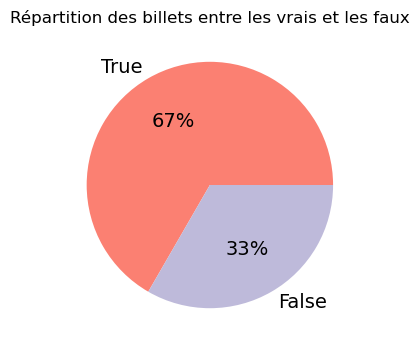

In [13]:
plt.figure(figsize=(6, 4))
billets.iloc[:,0].value_counts().plot(kind="pie",colors=couleurs,autopct = '%0.0f%%', textprops={'size':14})
plt.title('Répartition des billets entre les vrais et les faux')
plt.ylabel('')
plt.show()

><font color='#286363' size='3.5'>Dans notre jeu de données 1/3 des billets sont faux.</font>

## Vérification de la normalité des variables

In [14]:
#stockage du nom des variables quantitatives
var_quant = ['diagonal','height_left','height_right','margin_low','margin_up','length']

* **Distribution des variables**

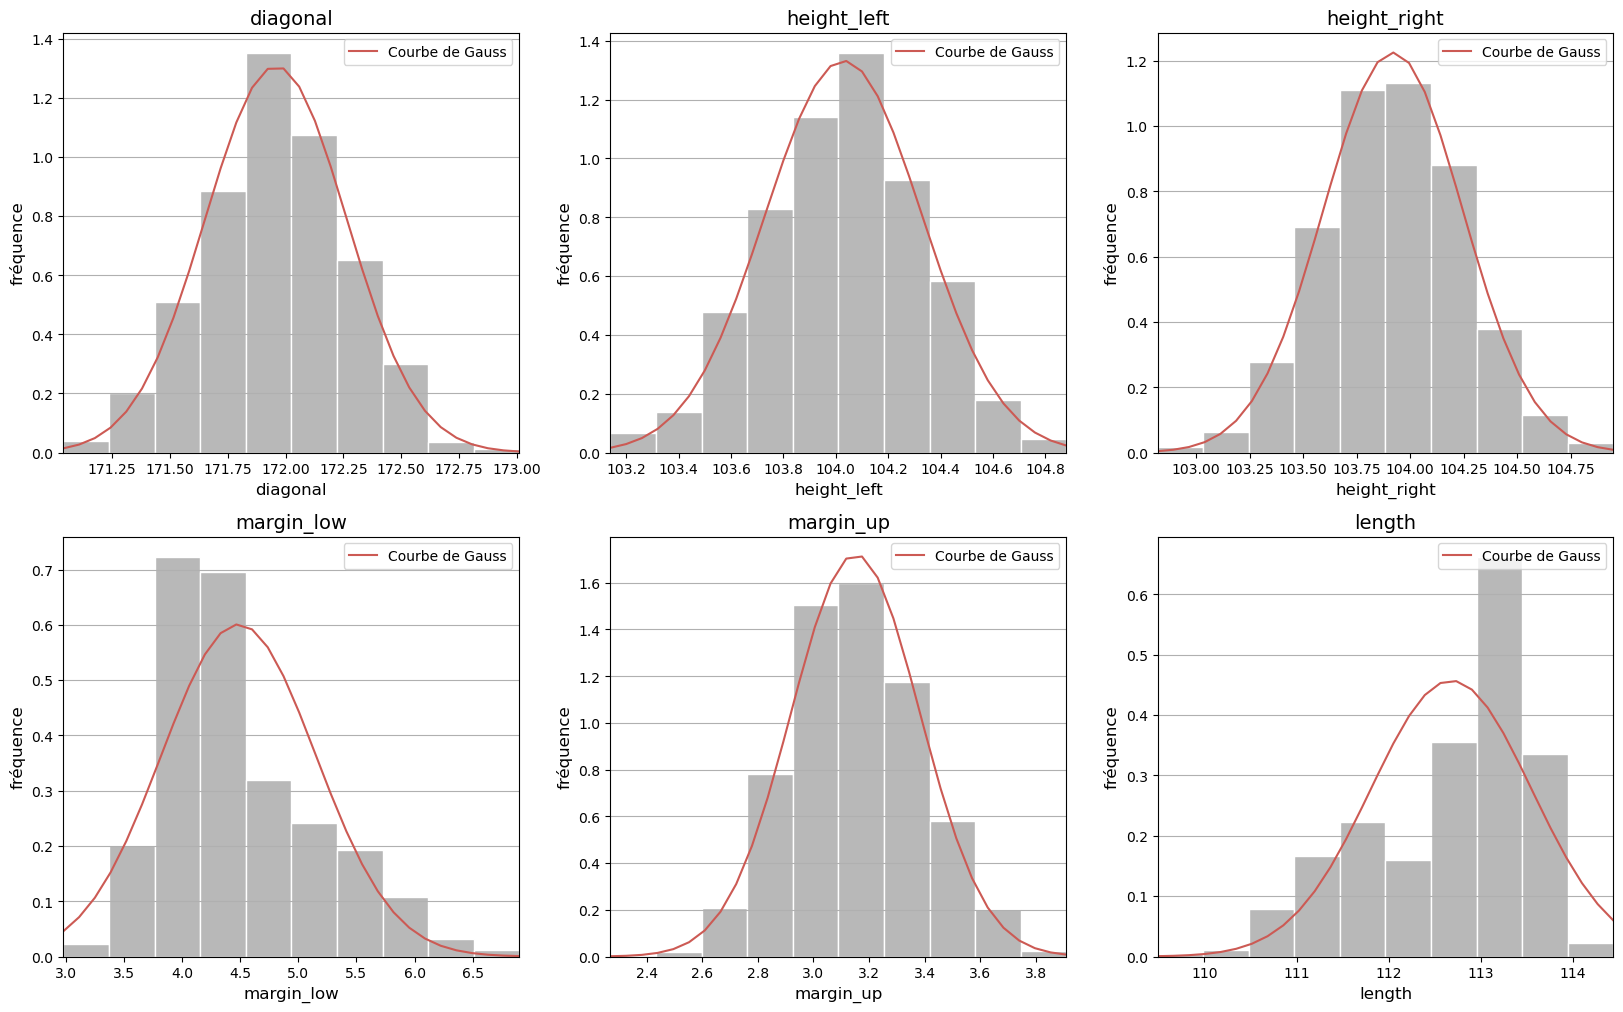

In [15]:
fig = plt.figure(figsize=(20, 12))
# représentation graphique de la distribution empirique de la variable price
for i,j,l in zip(var_quant,range(len(var_quant)),var_quant):
    ax = fig.add_subplot(231+j)
    graph_hist(billets[i],i,l)

In [16]:
#Création d'un dataframe temporaire qui exclus les individus avec des données manquantes 
billets_temp = billets.loc[~billets['margin_low'].isna()]

In [17]:
var_billets_temp = var_quant.copy()
var_billets_temp.pop(3)
var_margin_low = ['margin_low']

- Vérification de la normalité des variables via le test de Shapiro-Wilk<br/>
> <font color='#689696'>Hypothèse : la distribution suit-elle une loi normale ?<br/>
H0 : la variable suit une loi normale <br/>
H1 : la variable ne suit pas une loi normale </font>

In [18]:
for i in var_billets_temp :
    print(f'Variable {i} : {shapiro(billets[i])}')
print(f'Variable margin_low : {shapiro(billets_temp[var_margin_low])}')

Variable diagonal : ShapiroResult(statistic=0.9986855387687683, pvalue=0.32343590259552)
Variable height_left : ShapiroResult(statistic=0.9979010820388794, pvalue=0.0509396530687809)
Variable height_right : ShapiroResult(statistic=0.9995179772377014, pvalue=0.9806053638458252)
Variable margin_up : ShapiroResult(statistic=0.9961656928062439, pvalue=0.000810406228993088)
Variable length : ShapiroResult(statistic=0.9176009893417358, pvalue=7.863947037789753e-28)
Variable margin_low : ShapiroResult(statistic=0.9377837181091309, pvalue=2.8283876088209786e-24)


><font color='#286363' size='3.5'>Seules les 3 premières suivent une loi normale.<br/> Les 3 dernières variables (margin_low, margin_up et lenght) ont des valeurs de p inférieures à 5%, on peux donc rejeter l'hypothèse nulle et affirmer que ces variables ne suivent pas une loi normale.</font>

## Comparaison de la distribution des données

**Comparaison de la distribution de chaque variable entre les vrais et les faux billets**

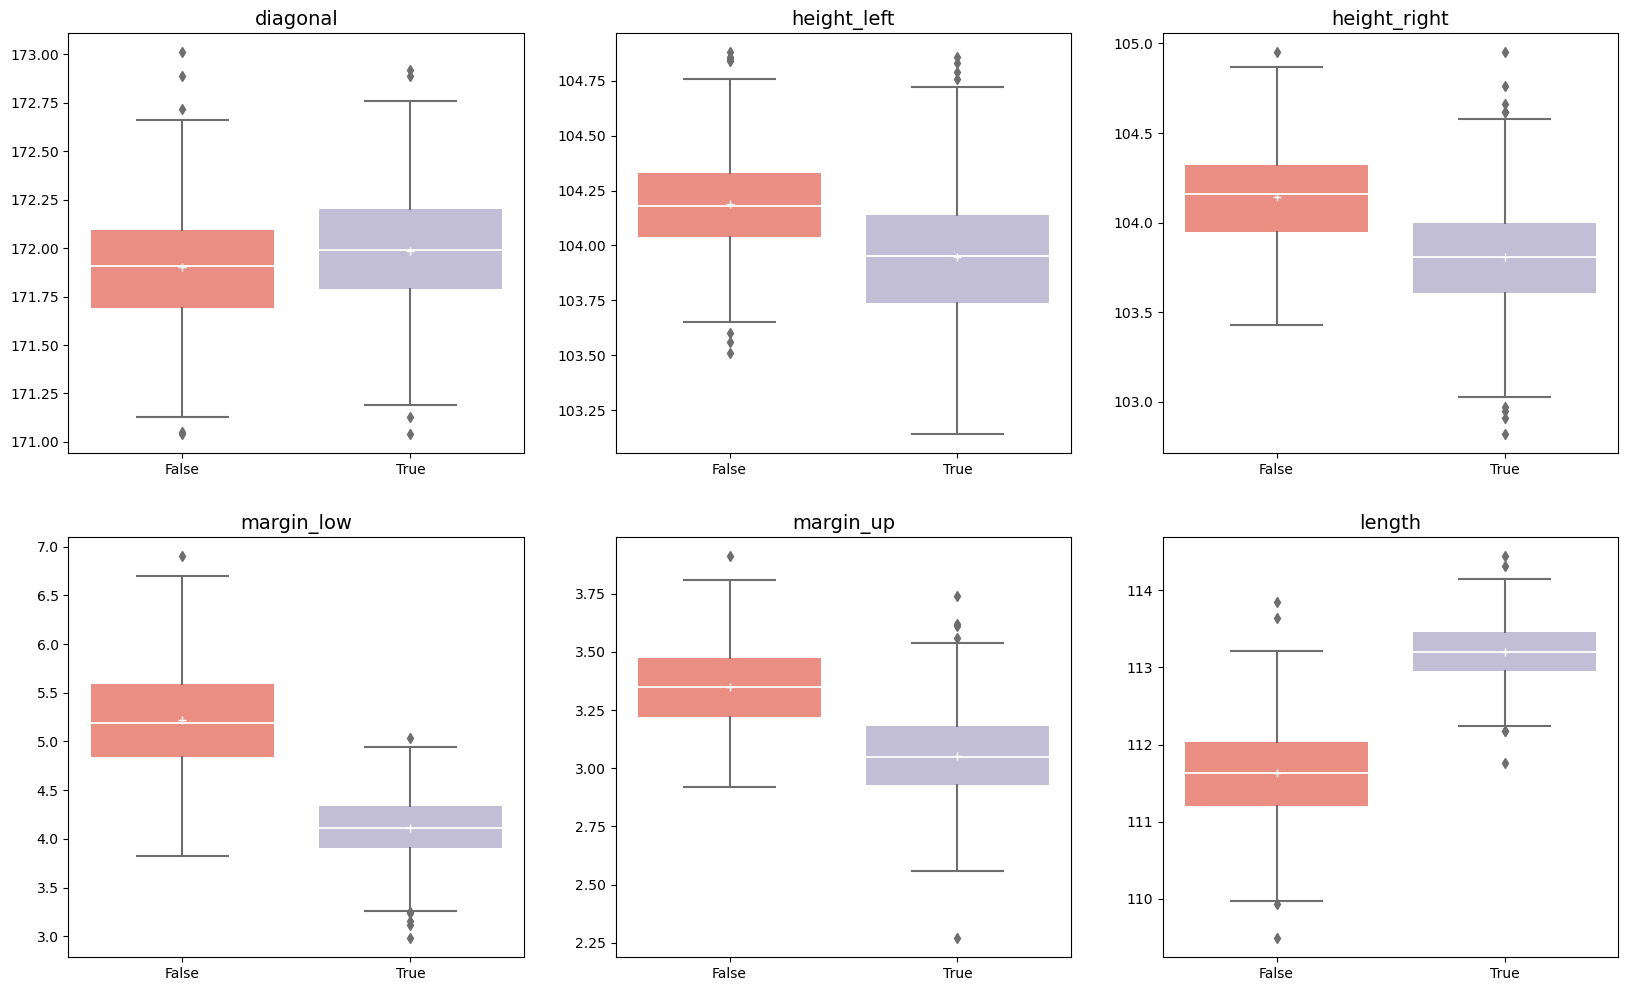

In [19]:
fig = plt.figure(figsize=(20, 12))
#Représentation graphique de la distribution empirique de la variable price
for i,j in zip(var_quant,range(len(var_quant))):
    ax = fig.add_subplot(231+j)
    sns.boxplot(x='is_genuine',y=i, data=billets ,palette=couleurs, boxprops = dict(linewidth=0), medianprops=dict(color='white',linewidth = 1.3), showmeans=True,meanprops={"marker": "+", "markeredgecolor": 'white'})  
    plt.xlabel('')
    plt.ylabel('')
    plt.title(i, fontsize=14)

><font color='#286363' size='3.5'>On peut remarquer des différences pour chaque variable entre les 2 groupes.

* **Vérification des différences entre les 2 groupes via des tests statistiques**

In [20]:
#Création des dataframes pour les tests
vrai = billets_temp.loc[billets['is_genuine']==True]
faux = billets_temp.loc[billets['is_genuine']==False]
vrai_margin_low = billets_temp[billets_temp['is_genuine']==True]['margin_low']
faux_margin_low = billets_temp[billets_temp['is_genuine']==False]['margin_low']

Vérification de l'existence de différences dans les différentes variables entre les 2 groupes<br/><i>Le test de Student est calculé sur les moyennes et le test U(test non paramétrique pour les variables ne suivant pas une loi normale) est calculé sur les sommes de rangs</i><br/>
> <font color='#689696'>Hypothèse : Y a-t-il une différence entre les billets faux et les billets vrais ?<br/>
H0 : les billets faux et les billets vrais ne présentent pas de différence significative <br/>
H1 : les billets faux et les billets vrais présentent une différence significative </font>

**Test de Student**<br/><i>Test sur l’égalité des moyennes des 3 premières variables qui suivent une loi normale</i>

In [21]:
for i in (var_quant[:3]):
    print(f'{i} :{ttest_ind(vrai[i],faux[i], equal_var=True)}')

diagonal :Ttest_indResult(statistic=5.1967708778045365, pvalue=2.3146624660826948e-07)
height_left :Ttest_indResult(statistic=-15.396007536819642, pvalue=1.1114157003736626e-49)
height_right :Ttest_indResult(statistic=-21.32295346909739, pvalue=4.708598379129022e-88)


><font color='#286363' size='3.5'>Les p value étant inférieures à 5% , elles confirment l'observation des boîtes à moustaches selon laquelle les 3 premières dimensions des billets sont significativement différentes entre les vrais et les faux billet.

**Test de Mann-Whitney**<br/><i>Test sur les sommes de rangs des 3 dernières variables qui ne suivent pas une loi normale</i>

In [22]:
for i in (var_quant[3:]):
    print(f'{i} :{mannwhitneyu(vrai[i],faux[i])}')    

margin_low :MannwhitneyuResult(statistic=19094.0, pvalue=3.0465930299427695e-182)
margin_up :MannwhitneyuResult(statistic=59858.0, pvalue=1.328995693686527e-121)
length :MannwhitneyuResult(statistic=470034.5, pvalue=2.0735965473634398e-201)


><font color='#286363' size='3.5'>Les p value étant inférieures à 5% , elles confirment l'observation des boîtes à moustaches selon laquelle les 3 dernières dimensions des billets sont significativement différentes entre les vrais et les faux billet.

## Relations entre les variables

<Figure size 2000x2000 with 0 Axes>

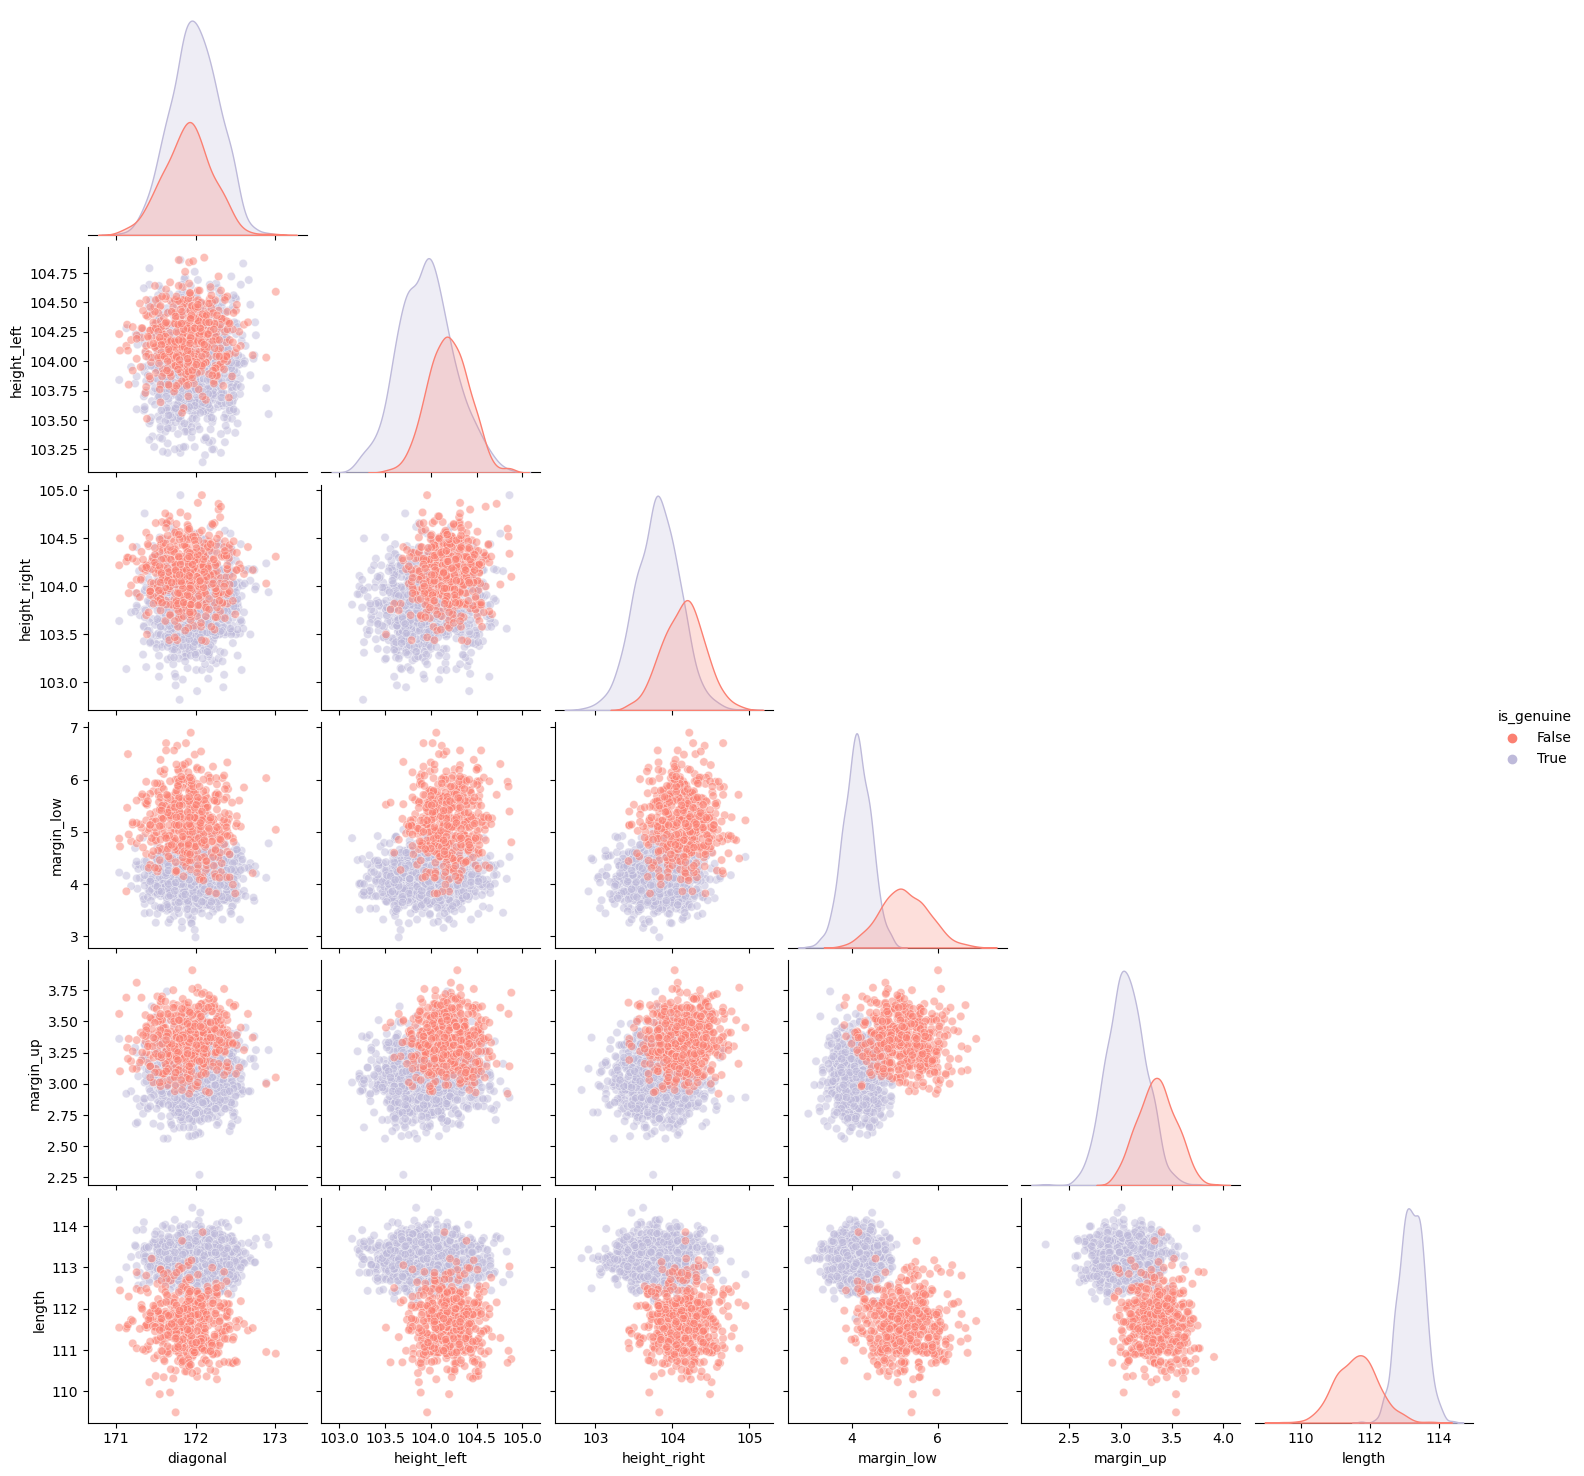

In [23]:
plt.figure(figsize=(20, 20))
sns.pairplot(billets, hue='is_genuine', palette=couleurs[:2], plot_kws={'alpha':0.5},corner=True)
plt.show()

><font color='#286363' size='3.5'>On remarque que la margin_low et le lenght sont les variables qui permettent le mieux de différencier les types de billets</font>

* **Matrice de corrélation**

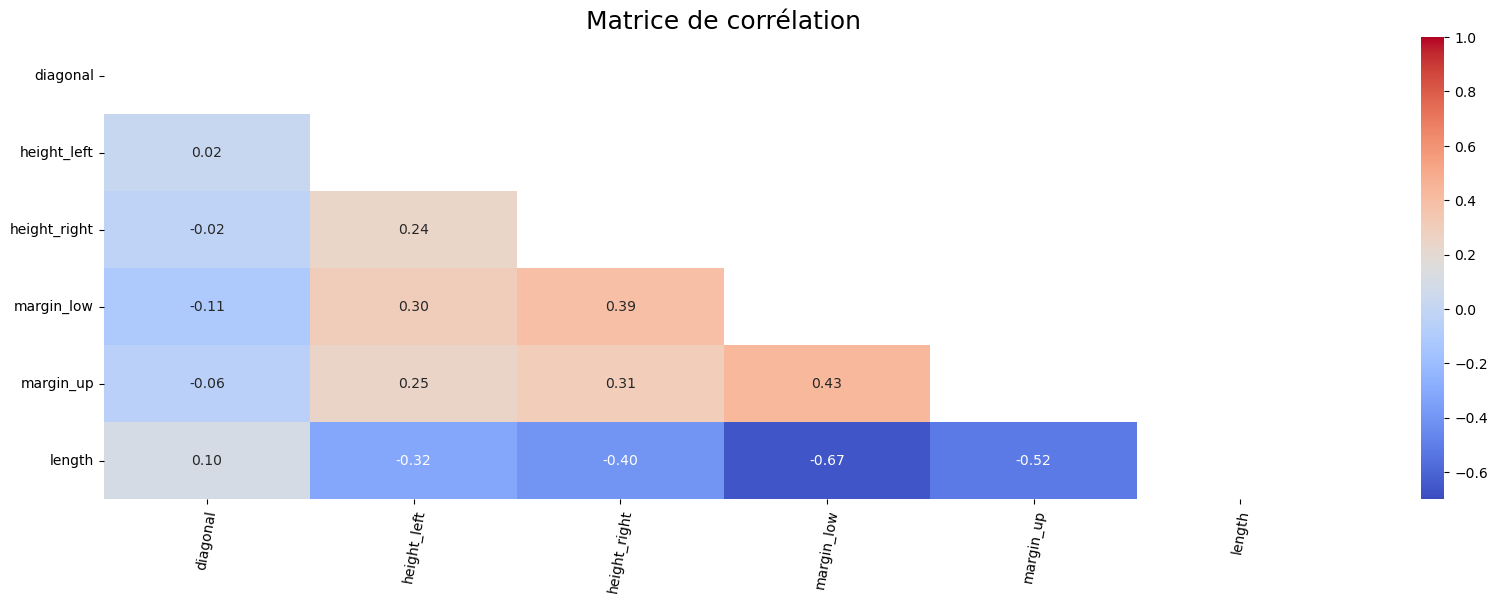

In [24]:
#Utilisation de la corrélation de Pearson
matrice = billets.iloc[:,1:].corr(method='pearson')
mask = np.triu(np.ones_like(matrice, dtype=np.bool_))
plt.figure(figsize=(20, 6))
sns.heatmap(matrice, mask=mask, cmap='coolwarm', vmin=-0.7, vmax=1, annot=True, fmt="0.2f")
plt.xticks(rotation=80,verticalalignment='top')
plt.title('Matrice de corrélation', fontsize = 18)
plt.show()

><font color='#286363' size='3.5'>Les variables les plus corrélées sont : <br/>
    - margin_low et length<br/>
    - margin_up et length </font>

# Traitement des valeurs manquantes

In [25]:
billets.isna().mean()

is_genuine      0.000000
diagonal        0.000000
height_left     0.000000
height_right    0.000000
margin_low      0.024667
margin_up       0.000000
length          0.000000
dtype: float64

In [26]:
billets['margin_low'].isna().sum()

37

> <font color='#286363' size='3.5'>Il manque 37 valeurs dans la variable margin_low</font>

**Distribution des données**

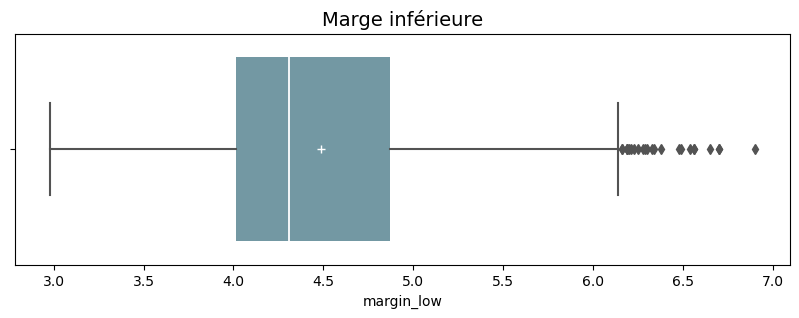

In [27]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
sns.boxplot(x='margin_low', data=billets ,palette=couleurs[2:], boxprops = dict(linewidth=0), medianprops=dict(color='white',linewidth = 1.3), showmeans=True, meanprops={"marker": "+", "markeredgecolor": 'white'})  
plt.title('Marge inférieure', fontsize=14)
plt.show()

In [28]:
print(f'Le minimum de la marge inférieure : {billets.margin_low.min()}')
print(f'Le maximum de la marge inférieure : {billets.margin_low.max()}')
print(f'La médiane de la marge inférieure : {round(billets.margin_low.median(),2)}')
print(f'La moyenne de la marge inférieure : {round(billets.margin_low.mean(),2)}')

Le minimum de la marge inférieure : 2.98
Le maximum de la marge inférieure : 6.9
La médiane de la marge inférieure : 4.31
La moyenne de la marge inférieure : 4.49


## Preprocessing

In [29]:
var_billets = ['is_genuine','diagonal','height_left','height_right','margin_low','margin_up','length']
var_explicatives = ['diagonal','height_left','height_right','margin_up','length']

In [30]:
#Utilisation du Dataframe dont on a soustrait les individus ayant une valeur manquante 
billets_temp.isna().mean()

is_genuine      0.0
diagonal        0.0
height_left     0.0
height_right    0.0
margin_low      0.0
margin_up       0.0
length          0.0
dtype: float64

In [31]:
billets_temp.shape

(1463, 7)

### Sampling

Création d'un jeu de données d'entrainement et d'un jeu de données test

In [32]:
df_train, df_test = train_test_split(billets_temp, train_size=0.8,random_state=2)

In [33]:
df_train.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
536,True,172.38,103.64,103.81,4.46,3.14,114.07
743,True,172.30,104.58,104.17,4.36,3.33,112.98
1392,False,171.59,104.17,104.09,5.25,3.08,112.14
521,True,171.89,104.30,103.57,3.98,2.75,112.92
1299,False,172.11,104.24,104.06,5.61,3.60,111.76


In [34]:
print (f'Le "train set" est composé de {df_train.shape[0]} lignes et le "test set" est composé de {df_test.shape[0]} lignes.')

Le "train set" est composé de 1170 lignes et le "test set" est composé de 293 lignes.


### Standardisation des données

In [35]:
scaler = StandardScaler().fit(df_train)
df_train_norm = scaler.transform(df_train)
df_train_norm = pd.DataFrame(df_train_norm, columns=var_billets) #ajout des noms de variables
df_test_norm = scaler.transform(df_test)
df_test_norm = pd.DataFrame(df_test_norm , columns=var_billets) #ajout des noms de variables

In [36]:
#Division du test set entre la variable à expliquer et les variables explicatives
X_test_norm = df_test_norm.drop(columns=['is_genuine','margin_low'])
y_test = df_test.margin_low.reset_index(drop = True)
X_train_norm = df_train_norm.drop(columns=['is_genuine','margin_low'])
y_train = df_train.margin_low.reset_index(drop = True)

## Régression linéaire multiple

><b><font color='#286363' size='3.5'>Principales hypothèses d’application de la régression linéaire :</font></b>
>- <font color='#689696'>Absence de colinéarité entre les variables explicatives</font>
>- <font color='#689696'>Distribution normale des résidus</font>
>- <font color='#689696'>Homéocédasticité des résidus</font>
>- <font color='#689696'>Les résidus sont supposés être indépendants </font>

* **Régression linéaire multiple**

In [37]:
reg_multi = smf.ols('margin_low ~ diagonal + height_left + height_right + margin_up + length', data=df_train_norm).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     219.0
Date:                Tue, 27 Dec 2022   Prob (F-statistic):          8.89e-165
Time:                        11:23:07   Log-Likelihood:                -1272.2
No. Observations:                1170   AIC:                             2556.
Df Residuals:                    1164   BIC:                             2587.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.493e-14      0.021    7.1e-13   

### Coefficient de détermination (R2) et variables significatives

* **Coefficient de détermination (R2)**

><font color='#286363' size='3.5'>Le coefficient de détermination 𝑅2 n'est pas très élevé. En effet il vaut environ 0.48, tout comme le 𝑅2 ajusté.</font>

* **Variables significatives**

**Test de Student sur les coefficients de corrélation**

> <font color='#689696'>Hypothèse : Les variables sont-elles significatives ?<br/>
H0 : la variable est non significative <br/>
H1 : la variable est significative </font>

><font color='#286363' size='3.5'>Les p value étant inférieures à 5%, on rejette l'hypothèse nulle, toutes  les  variables  sont donc significatives.</font>

### Vérification de la colinéarité des variables

**Calcul des facteurs d'inflation de la variance**

In [38]:
variables = reg_multi.model.exog
vif = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], columns = ['VIF'])
vif.index=var_explicatives
vif

,VIF
diagonal,1.015474
height_left,1.157636
height_right,1.254162
margin_up,1.382347
length,1.579725


><font color='#286363' size='3.5'>La non-colinéarité est vérifiée puisque les valeurs VIF sont inférieures à 10.</font>

### Analyses des valeurs atypiques et influentes

In [39]:
n = df_train_norm.shape[0]
p = 5

In [40]:
#Création d'un dataframe où les résultats des tests seront stockés
analyses = pd.DataFrame({'obs':np.arange(0, n)})

#### Atypicité sur les variables explicatives

In [41]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag
#seuil
seuil_levier = 2*p/n
seuil_levier

0.008547008547008548

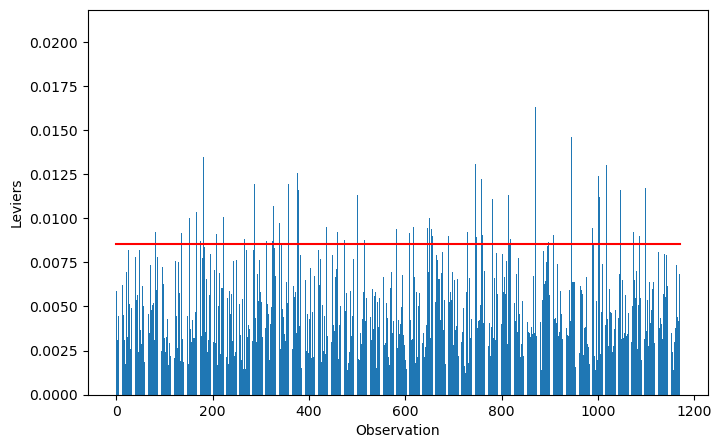

In [42]:
plt.figure(figsize=(8,5))
plt.bar(analyses['obs'], analyses['levier'])
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1170], [seuil_levier, seuil_levier], color='r')
plt.show()

In [43]:
#Stockage des observations pour lesquelles le levier est supérieur au seuil
lev = analyses.loc[analyses['levier'] > seuil_levier, :].obs
lev.shape

(124,)

#### Atypicité sur la variable à expliquer

In [44]:
#réalisation du test à un niveau 𝛼=5% 
alpha = 0.05
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
#seuil
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

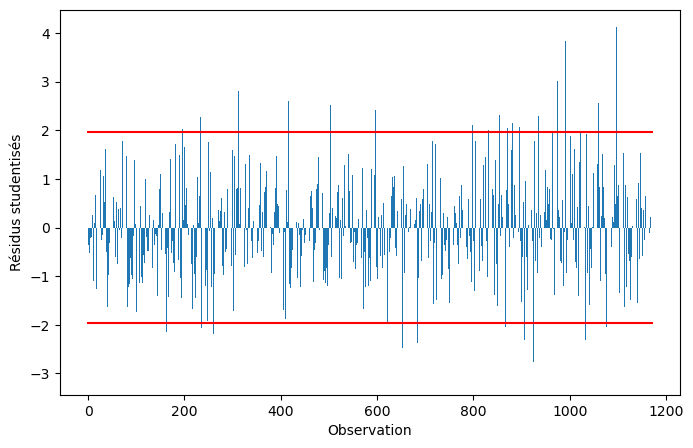

In [45]:
plt.figure(figsize=(8,5))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1170], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1170], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

**Identification des observations pour lesquelles les résidus studentisés sont supérieurs au seuil**

In [46]:
#Stockage des observations pour lesquels les résidus studentisés sont supérieurs au seuil
rst = analyses.loc[(analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent) , :].obs
rst.shape

(62,)

#### Influence des observations via la distance de cook

In [47]:
influence = reg_multi.get_influence().summary_frame()

In [48]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

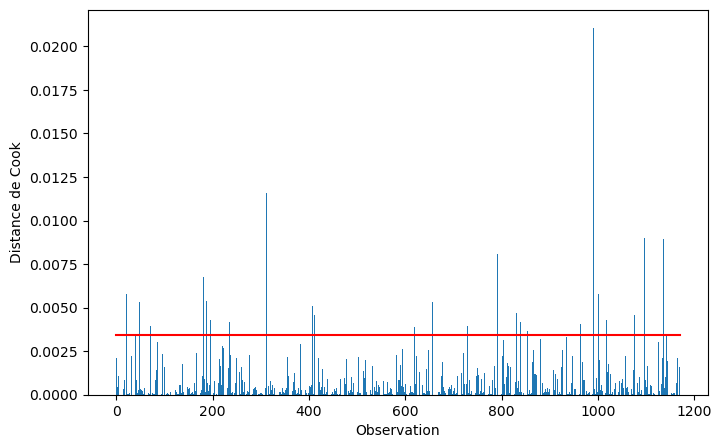

In [49]:
plt.figure(figsize=(8,5))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xlabel('Observation')
plt.ylabel('Distance de Cook')
plt.plot([0, 1170], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [50]:
#Stockage des observations influentes
dcook = analyses.loc[analyses['dcooks'] > seuil_dcook , :].obs
dcook.shape

(68,)

### Eviction des observations atypiques et influentes

#### Détection des observations atypiques et influentes

In [51]:
#Intersection des observations atypiques sur les variables explicatives et influentes
lev_dcook = pd.merge(lev,dcook, how ='inner').obs
lev_dcook.shape

(24,)

In [52]:
#Intersection des observations atypiques sur la variable à expliquer et influentes
rst_dcook = pd.merge(rst,dcook, how ='inner').obs
rst_dcook.shape

(45,)

#### Eviction des observations atypiques et influentes

In [53]:
df_train_norm = df_train_norm.loc[~df_train_norm.index.isin(lev_dcook)]
df_train_norm = df_train_norm.loc[~df_train_norm.index.isin(rst_dcook)]
df_train_norm.shape

(1110, 7)

In [54]:
df_train_norm.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0.711190,1.362828,-1.323006,-0.350024,-0.035344,-0.063615,1.603281
1,0.711190,1.098278,1.891490,0.762152,-0.185990,0.767270,0.350469
2,-1.406094,-1.249603,0.489423,0.515002,1.154761,-0.326000,-0.615001
3,0.711190,-0.257541,0.933981,-1.091474,-0.758446,-1.769117,0.281507
4,-1.406094,0.469972,0.728800,0.422321,1.697087,1.948002,-1.051761


### Réentraînement de l'algorithme

In [55]:
reg_multi = smf.ols('margin_low ~ diagonal + height_left + height_right + margin_up + length', data=df_train_norm).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     267.5
Date:                Tue, 27 Dec 2022   Prob (F-statistic):          2.11e-187
Time:                        11:23:14   Log-Likelihood:                -1041.2
No. Observations:                1110   AIC:                             2094.
Df Residuals:                    1104   BIC:                             2124.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0188      0.019     -1.011   

><font color='#286363' size='3.5'>L'éviction des valeurs atypiques et influentes a permis d'améliorer le coefficient de détermination 𝑅2 et le 𝑅2 ajusté, qui valent maintenant 0,55.</font>

### Résidus

* **Vérification de l’hypothèse d’indépendance des résidus**

> <font color='#689696'>Hypothèse : Y a-t-il autocorrélation des résidus ?<br/>
H0 : il y a non auto-corrélation <br/>
H1 : il y a auto-corrélation  <br/></font>
La statistique de Durbin-Watson prend une valeur entre 0 (auto-corrélation linéaire positive) et 4 (auto-corrélation linéaire négative). L'hypothèse nulle est retenue si la statistique a une valeur proche de 2 (pas d'auto-corrélation linéaire).

In [56]:
print(f'La statistique de Durbin et Watson est d\'environ {round(durbin_watson(reg_multi.resid),2)}')

La statistique de Durbin et Watson est d'environ 1.99


><font color='#286363' size='3.5'>La valeur étant proche de 2, il y a une indépendance des résidus.</font>

* **Vérification de la normalité des résidus**

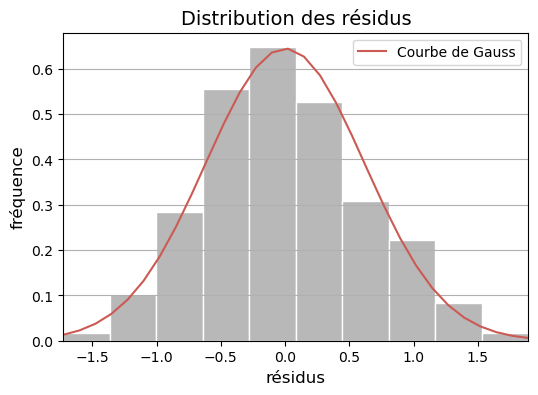

In [57]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
graph_hist(reg_multi.resid,"résidus",'Distribution des résidus')
plt.show()

- Vérification de la normalité des résidus via le test statistique de Shapiro<br/>
> <font color='#689696'>Hypothèse : la distribution suit-elle une loi normale ?<br/>
H0 : la variable suit une loi normale <br/>
H1 : la variable ne suit pas une loi normale </font>

In [58]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9931902885437012, pvalue=5.6488337577320635e-05)

<font color='#286363' size='3.5'>La valeur de p étant inférieure à 5%, on rejète l'hypothèse nulle. Les résidus ne suivent une loi normale.<br/>
Néanmoins, nous avons un grand échantillon (> 30).</font>

* **Vérification de l'homoscédasticité des résidus**

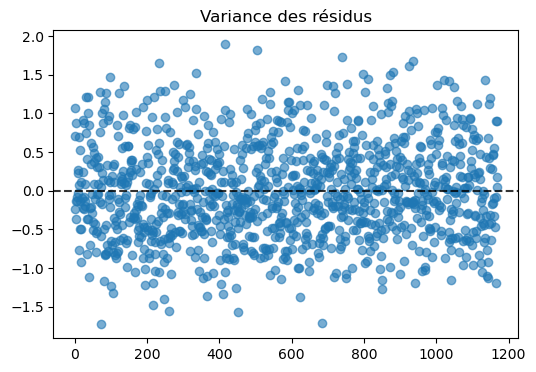

In [59]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
plt.scatter(x=df_train_norm.index, y=reg_multi.resid, alpha=0.6)
plt.axhline(y=reg_multi.resid.mean(),linestyle='--',color='black', alpha=0.8)
plt.title('Variance des résidus')
plt.show()

* Vérification de l'homoscédasticité des résidus via le test Breusch Pagan<br/>
> <font color='#689696'>
    H0 (hypothèse nulle) : homoscédasticité<br/>
    Ha (hypothèse alternative) : hétéroscédasticité</font>

In [60]:
variables = reg_multi.model.exog[:,1:]
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('test Breusch Pagan :', _,'\np value :',pval)

test Breusch Pagan : 19.12833480565347 
p value : 0.0007416007280536676


><font color='#286363' size='3.5'>La valeur de p étant inférieure à 5%, on rejète l'hypothèse nulle.<br/>
Les résidus ne sont pas homoscédastiques.</font>

### Evaluation du modèle

* **Train set**

In [61]:
y_pred_train = (reg_multi.predict(X_train_norm)*scaler.var_[4]) + scaler.mean_[4]
df_train = df_test.reset_index(drop=True)
df_train['prediction']=y_pred_train
df_train['erreur']=df_train['prediction']-df_train['margin_low']
df_train.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,prediction,erreur
0,True,171.60,103.55,103.74,3.79,2.86,112.82,3.998895,0.208895
1,True,171.84,103.59,103.98,4.09,3.05,113.09,4.505525,0.415525
2,False,171.76,104.13,104.19,5.22,3.55,111.90,4.677975,-0.542025
3,True,171.52,103.85,103.75,3.95,3.09,112.97,4.310460,0.360460
4,True,171.70,103.77,103.88,4.10,2.96,112.91,4.844334,0.744334


**L'écart quadratique moyen sur le train set**<br/><i>écart-type des résidus (erreurs de prévision)</i>

In [62]:
#RMSE =  (même unité que la donnée à prédire)
print(f'L\'écart quadratique moyen sur le train set est de {round(np.sqrt(mean_squared_error(y_train, y_pred_train, squared=True)),2)}mm')

L'écart quadratique moyen sur le train set est de 0.5mm


* **Test set**

In [63]:
y_pred = (reg_multi.predict(X_test_norm)*scaler.var_[4]) + scaler.mean_[4]
df_test = df_test.reset_index(drop=True)
df_test['prediction']=y_pred
df_test['erreur']=df_test['prediction']-df_test['margin_low']
df_test.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,prediction,erreur
0,True,171.60,103.55,103.74,3.79,2.86,112.82,4.321146,0.531146
1,True,171.84,103.59,103.98,4.09,3.05,113.09,4.311575,0.221575
2,False,171.76,104.13,104.19,5.22,3.55,111.90,4.827394,-0.392606
3,True,171.52,103.85,103.75,3.95,3.09,112.97,4.356586,0.406586
4,True,171.70,103.77,103.88,4.10,2.96,112.91,4.356214,0.256214


**L'écart quadratique moyen (RMSE) sur le test set**

In [64]:
#RMSE =  (même unité que la donnée à prédire)
print(f'L\'écart quadratique moyen sur le test set est de {round(np.sqrt(mean_squared_error(y_test, y_pred, squared=True)),2)}mm.')

L'écart quadratique moyen sur le test set est de 0.51mm.


><font color='#286363' size='3.5'>On remarque que l'écart quadratique moyen du jeu de test et celui du jeu d'entrainement est proche. Nous pouvons donc valider la stabilité de ce modèle.<br/>Même si cet algorithme n'est pas idéal puisqu'il ne repond pas à toutes les hypothèses, nous l'utiliserons pour remplacer les valeurs manquantes. <br/> </font> 

### Remplacement des valeurs nulles

In [65]:
billets_norm = scaler.transform(billets)
billets_norm = pd.DataFrame(billets_norm, columns=var_billets)
billets_norm['margin_predict'] = reg_multi.predict(billets_norm[['diagonal','height_left','height_right','margin_up','length']])

In [66]:
for i in (billets.loc[billets['margin_low'].isna()].index):
    billets.loc[billets.index == i,'margin_low'] = (billets_norm.loc[billets_norm.index == i,'margin_predict']*scaler.var_[4]) + scaler.mean_[4]

In [67]:
billets.isna().mean()

is_genuine      0.0
diagonal        0.0
height_left     0.0
height_right    0.0
margin_low      0.0
margin_up       0.0
length          0.0
dtype: float64

><font color='#286363' size='3.5'>Notre jeu de données est maintenant complet</font>

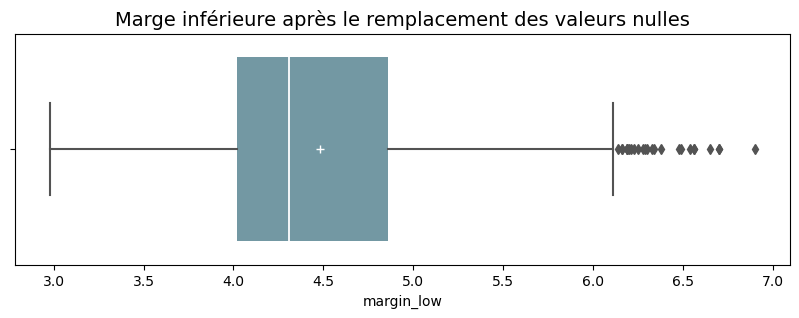

In [68]:
fig = plt.figure(figsize=(10, 3))
sns.boxplot(x='margin_low', data=billets ,palette=couleurs[2:], boxprops = dict(linewidth=0), medianprops=dict(color='white',linewidth = 1.3), showmeans=True, meanprops={"marker": "+", "markeredgecolor": 'white'})  
plt.title('Marge inférieure après le remplacement des valeurs nulles', fontsize=14)
plt.show()

# Modélisation

## Preprocessing

### X & y

y est la variable à expliquer et X la série de variables explicatives

In [69]:
X = billets.drop(columns='is_genuine')
y = billets.is_genuine

In [70]:
X.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [71]:
y.head()

0    True
1    True
2    True
3    True
4    True
Name: is_genuine, dtype: bool

### Sampling

Mise en place du training set et du testing set

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=7)

### Standardisation des données

In [73]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [74]:
X_train_norm = pd.DataFrame(X_train_norm,columns=var_quant)
X_test_norm = pd.DataFrame(X_test_norm,columns=var_quant)

In [75]:
print(f'X_train_norm et y_train contiennent {X_train_norm.shape[0]} lignes.')
print(f'X_test_norm et y_test contiennent {X_test_norm.shape[0]} lignes.')

X_train_norm et y_train contiennent 1050 lignes.
X_test_norm et y_test contiennent 450 lignes.


## Régression logistique

> <b><font color='#286363' size='3.5'>Les principales hypothèses d’application de la régression logistique :</font></b>
>- <font color='#689696'>La variable dépendante doit être classée en deux catégories.</font>  Notre variable dépendante valide cette hypothèse.
>- <font color='#689696'>Les variables indépendantes ne doivent pas avoir de multi-colinéarité.</font> <font color=#595959>Nous allons le vérifier avec le calcul du facteur d'inflation de la variance (VIF).</font>
>- <font color='#689696'>L’analyse de régression logistique nécessite un échantillon de grande taille.</font> Notre échantillon comporte 1500 individus.

### Vérification de la colinéarité des variables

In [76]:
vif = pd.DataFrame([variance_inflation_factor(X_train_norm.values, i) for i in np.arange(0,X_train_norm.shape[1])], columns = ['VIF'])
vif.index=var_quant

In [77]:
vif

,VIF
diagonal,1.017762
height_left,1.186895
height_right,1.308269
margin_low,1.952982
margin_up,1.394126
length,2.181982


><font color='#286363' size='3.5'>La non-colinéarité est vérifiée puisque les valeurs VIF sont inférieures à 10.</font>

### Entrainement du modèle

In [78]:
#Modèle de régression logistique
modele1 = LogisticRegression()

In [79]:
modele1.fit(X_train_norm, y_train)

LogisticRegression()

In [80]:
y_pred = modele1.predict(X_test_norm)
y_proba = modele1.predict_proba(X_test_norm)[:, 1]

#### Matrice de confusion

<font color='#286363' size='3.5'>La matrice de confusion compare les données réelles pour une variable cible à celles prédites par un modèle</font>

<font color='#286363' size='3.5'>
    <ul><li><b> Précision</b> = True Positif / (True Positif + False Positif)</li>
    <li><b> Sensitivité (ou recall)</b> = True Positif / (True Positif + False Negatif)</li>
    <li><b> Specificité</b> = True Negatif / (True Negatif + False Positif)</li>
    <li><b> Accuracy score</b> = Efficacité du modèle à prédire correctement les individus positifs et négatifs</li></ul></font>

In [81]:
conf_test_m1 = confusion(y_test, y_pred)
conf_test_m1

,Billet prédit Faux,Billet prédit Vrai
Billet Faux,133,4
Billet Vrai,1,312


#### Performances sur le test

In [82]:
mesures('Régression logistique ->', y_test, y_pred)

'Régression logistique -> Précision : 0.987, Rappel : 0.997, Spécificité : 0.971, Accuracy score : 0.989'

> <font color='#286363' size='3.5'>Dans ce projet nous recherchons à identifier les faux billets.<br/>
Ainsi dans la matrice de confusion, un "True négative" est un faux billet prédit faux. Nous recherchons donc ici à minimiser les faux billets prédit vrai(False Positive), et donc à maximiser la précision.<br/><br/>La précision sur le train set est de 99%</font>

### Sélection de variables significatives

In [83]:
#Utilisation de la classe "recursive feature elimination" de scikit learn
select = RFE(estimator=modele1)
select.fit(X_train_norm,y_train)

RFE(estimator=LogisticRegression())

In [84]:
modele1.coef_

array([[ 0.32314457, -0.56896726, -0.85056127, -2.75458897, -1.50847711,
         3.26780733]])

In [85]:
#Affichage du numéro de rang de chaque variable 
print(f'Nombre de variables {select.n_features_}')
print(select.ranking_)

Nombre de variables 3
[4 3 2 1 1 1]


In [86]:
var_signif = X_train_norm.columns[select.support_]
print(f'Variables signicatives : {var_signif}')

Variables signicatives : Index(['margin_low', 'margin_up', 'length'], dtype='object')


><font color='#286363' size='3.5'>Les variables 'margin_low', 'margin_up', 'length' sont significatives.</font>

In [87]:
#Sélection des variables significatives dans les sets d'entrainement et de test
X_train_vs = X_train_norm[var_signif]
X_test_vs = X_test_norm[var_signif]

#### Réentrainement du modèle avec uniquement les variables significatives

In [88]:
modele1.fit(X_train_vs, y_train)

LogisticRegression()

#### Calcul des prédictions et des probabilités sur le test set

In [89]:
y_pred = modele1.predict(X_test_vs)
y_proba = modele1.predict_proba(X_test_vs)[:, 1]

#### Matrice de confusion

In [90]:
conf_test_m1 = confusion(y_test, y_pred)
conf_test_m1

,Billet prédit Faux,Billet prédit Vrai
Billet Faux,133,4
Billet Vrai,0,313


#### Performances

In [91]:
mesures('Régression logistique ->',y_test, y_pred)

'Régression logistique -> Précision : 0.987, Rappel : 1.0, Spécificité : 0.971, Accuracy score : 0.991'

><font color='#286363' size='3.5'>On remarque une légère amélioration des performances</font>

### Courbe de ROC

In [92]:
#Calcul de la sensibilité, de la spécificité, et du seuil
[fpr, tpr, thr] = roc_curve(y_test, y_proba)

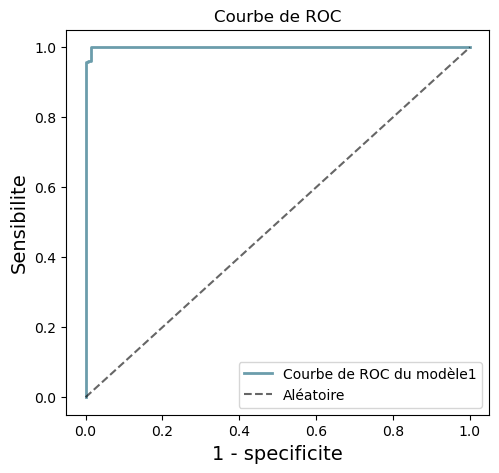

In [93]:
x_max = fpr[np.where(tpr > 0.98)][0]
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
plt.plot(fpr, tpr, color=couleurs[2], lw=2, label="Courbe de ROC du modèle1")
plt.plot(fpr,fpr, linestyle='--',color='black', alpha=0.6, label="Aléatoire")
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)
plt.legend()
plt.title('Courbe de ROC')
plt.show()

**Calcul de l'aire sous la courbe**

In [94]:
print(f'Air sous la courbe ROC : {round(auc(fpr, tpr),3)}')

Air sous la courbe ROC : 0.999


> <font color='#286363' size='3.5'>Le calcul de l'air sous la courbe ROC nous confirme l'observation de la courbe de ROC qui nous montre que le modèle est performant. En effet plus l'air est proche de 0,5 moins il est performant puisqu'il se rapproche d'une estimation aléatoire et plus il est proche de 1 plus le modèle de classification est parfait.<br/><br/>Par ailleurs, nous garderons le seuil de 0,5 </font>

#### Cross validation

In [95]:
cv = StratifiedKFold(5)
cv_results_accuracy = cross_val_score(modele1, X_train, y_train, cv=cv)
cv_results_precision = cross_val_score(modele1, X_train, y_train, cv=cv, scoring="precision")
print(f'Accuracy score : {cv_results_accuracy.round(3)} \nPrecision : {cv_results_precision.round(3)}')

Accuracy score : [0.986 0.99  0.986 0.981 1.   ] 
Precision : [0.993 1.    0.979 0.978 1.   ]


In [96]:
print(f'Moyenne de précision : {cv_results_precision.mean().round(3)}  \nMoyenne d\'accuracy score : {cv_results_accuracy.mean().round(3)}')

Moyenne de précision : 0.99  
Moyenne d'accuracy score : 0.989


#### Calcul des mesures sur le test set

**Calcul des mesures**

In [97]:
mesures_modele1 = mesures('Régression logistique ->', y_test, y_pred)
mesures_modele1

'Régression logistique -> Précision : 0.987, Rappel : 1.0, Spécificité : 0.971, Accuracy score : 0.991'

><font color='#286363' size='3.5'>La précision et l'acuracy score sur le test set est équivalent aux moyennes de la cross validation, on peut donc dire qu'il n' y a pas surapprentissage sur ce modèle.</font>

## K-means

In [98]:
#Choix du nombre de cluster
modele2 = KMeans(n_clusters=2, random_state=2)
#Entrainement du modèle
modele2.fit(X_train_norm)

KMeans(n_clusters=2, random_state=2)

In [99]:
#Centroides pour chaque variable des 2 clusters
centroides = modele2.cluster_centers_
centroides

array([[ 0.08744461, -0.31475422, -0.39044315, -0.5737038 , -0.43986622,
         0.6159608 ],
       [-0.16410838,  0.59070313,  0.73274947,  1.076677  ,  0.82550236,
        -1.15598123]])

In [100]:
#Création d'un dataframe pour stocker les prédictions
resultats = pd.DataFrame(X_train_norm).copy()

In [101]:
#Affectation des labels selon les clusters créés 
y_pred_train = 1-modele2.labels_

In [102]:
resultats['Prediction'] = y_pred_train
resultats.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,Prediction
0,0.977691,-0.335107,-1.328924,-0.504045,-1.546153,1.008239,1
1,0.390480,1.521600,0.916290,2.498928,-0.352757,-1.626727,0
2,-1.077548,-1.768354,-1.055857,-0.831101,-0.662156,0.492458,1
3,-0.066240,0.381517,0.157772,0.090603,1.857236,0.055166,0
4,-0.490337,-1.051731,-0.782791,-0.043193,0.133441,0.111229,1


### Evaluation de la performance

#### Train set

**Matrice de confusion**

In [103]:
conf_train_m2 = confusion(y_train,y_pred_train)
conf_train_m2

,Billet prédit Faux,Billet prédit Vrai
Billet Faux,356,7
Billet Vrai,9,678


**Calcul des mesures**

In [104]:
mesures('KMeans ->',y_train, y_pred_train)

'KMeans -> Précision : 0.99, Rappel : 0.987, Spécificité : 0.981, Accuracy score : 0.985'

#### Test set

**Calcul des prédictions sur le test set**

In [105]:
#Calcul des distances euclidiennes par rapport aux centroides et affectation à un des 2 clusters
y_pred = 1-modele2.predict(X_test_norm)

**Matrice de confusion**

In [106]:
conf_test_m2 = confusion(y_test, y_pred)
conf_test_m2

,Billet prédit Faux,Billet prédit Vrai
Billet Faux,131,6
Billet Vrai,2,311


**Calcul des mesures**

In [107]:
mesures_modele2 = mesures('KMeans ->', y_test, y_pred)
mesures_modele2

'KMeans -> Précision : 0.981, Rappel : 0.994, Spécificité : 0.956, Accuracy score : 0.982'

><font color='#286363' size='3.5'>La précision et l'accuracy score sur le test set sont équivalents à ceux du train set</font>

## Comparaison des 2 modèles

**Modele 1 : Regression logistique**

In [108]:
mesures_modele1

'Régression logistique -> Précision : 0.987, Rappel : 1.0, Spécificité : 0.971, Accuracy score : 0.991'

**Modele 2 : K-means**

In [109]:
mesures_modele2

'KMeans -> Précision : 0.981, Rappel : 0.994, Spécificité : 0.956, Accuracy score : 0.982'

><font color='#286363' size='3.5'>Les 2 modèles fournissent une très bonne performance. <br/>Néanmoins le taux de prédiction est meilleur avec la régression logistique, ainsi que la précision, qui est la mesure que l'on souhaite maximiser afin de mieux détecter les billets faux.<br/>
C'est pourquoi la régression logistique est retenu.</font>

## Application du modèle d'estimation de détection des faux billets

In [110]:
# import des données
billets = pd.read_csv('billets_test.csv', sep = ',')

In [111]:
#Standardisation du dataframe 
df = billets.drop(columns='id')
var = df.columns.values
df_norm = scaler.transform(df)
df_norm = pd.DataFrame(df_norm,columns=var)

In [112]:
#Sélection des variables significatives
df_vs = df_norm[var_signif]

In [113]:
#Estimatation avec le modele selectionné 
pred = modele1.predict(df_vs)
prob = modele1.predict_proba(df_vs).max(axis = 1)

In [114]:
#Stockage des prédictions et des probabilités
billets["prediction"]= pred
billets["probabilite"]= prob.round(3)
billets

,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction,probabilite
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,True,0.991
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,False,0.995
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,True,0.999
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,False,1.000
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,False,0.962


In [115]:
nb_billets_faux = len(billets)-billets.prediction.sum()
id_billets_faux = billets.loc[billets.prediction == 0].id.values
print(f'Sur les {len(billets)} billets, le modèle a estimé qu\'il y avait {nb_billets_faux} billets faux, dont les id sont : {id_billets_faux}' )

Sur les 5 billets, le modèle a estimé qu'il y avait 3 billets faux, dont les id sont : ['B_2' 'B_4' 'B_5']
